Number of pre-filtered glasses: 8
Number of glasses dispensed: 235
Number of removed unsuccessful searches that were very close in time: 12
Number of pre-filtered glasses: 0
Number of unsuccessful searches: 43
Number of glasses used for clustering: 278


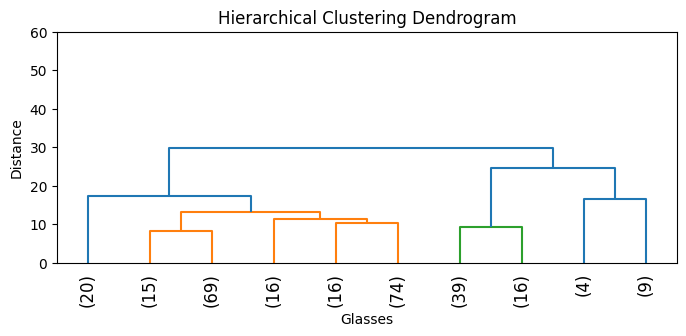

Number of removed unsuccessful searches that were same cluster and close in time: 1
cluster
1     11.0
2    171.0
3     53.0
4      0.0
Name: dispense_cluster_count, dtype: float64


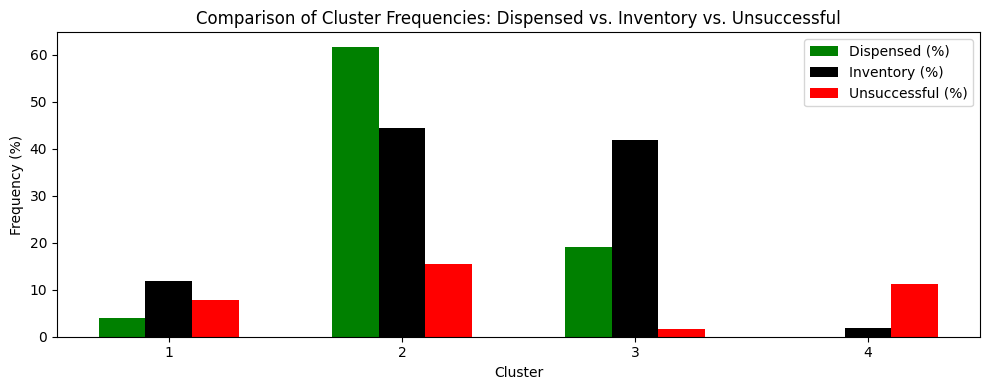

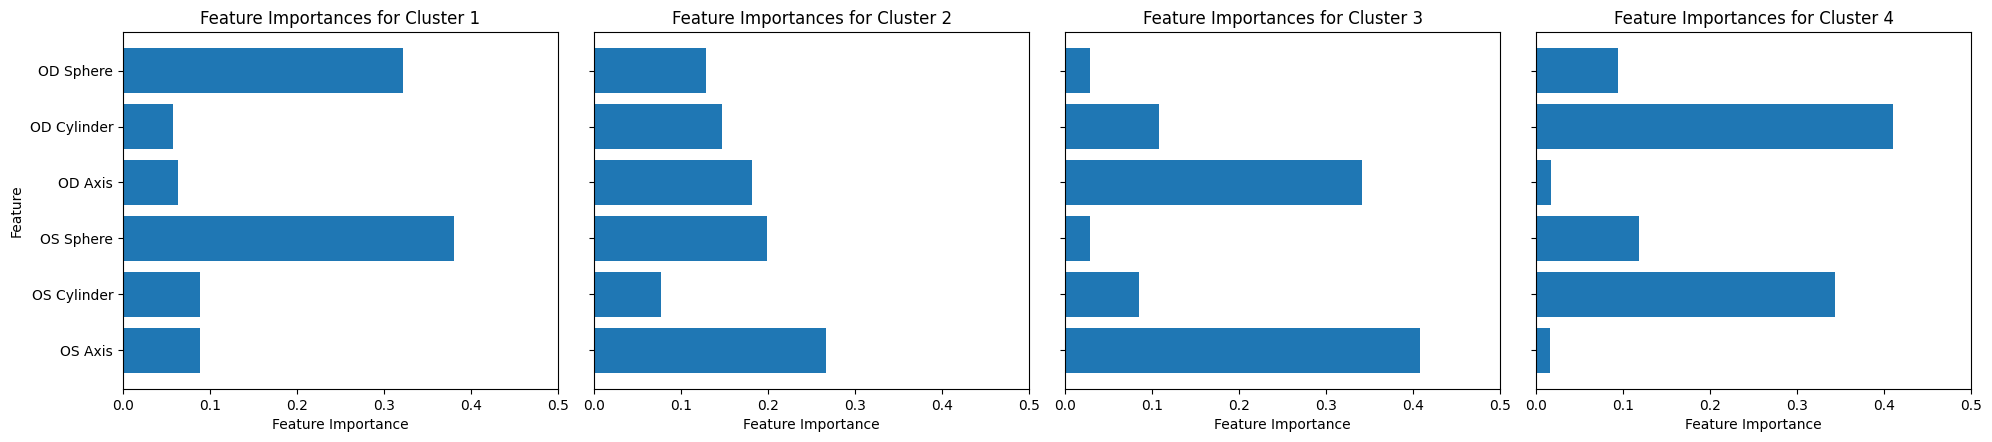

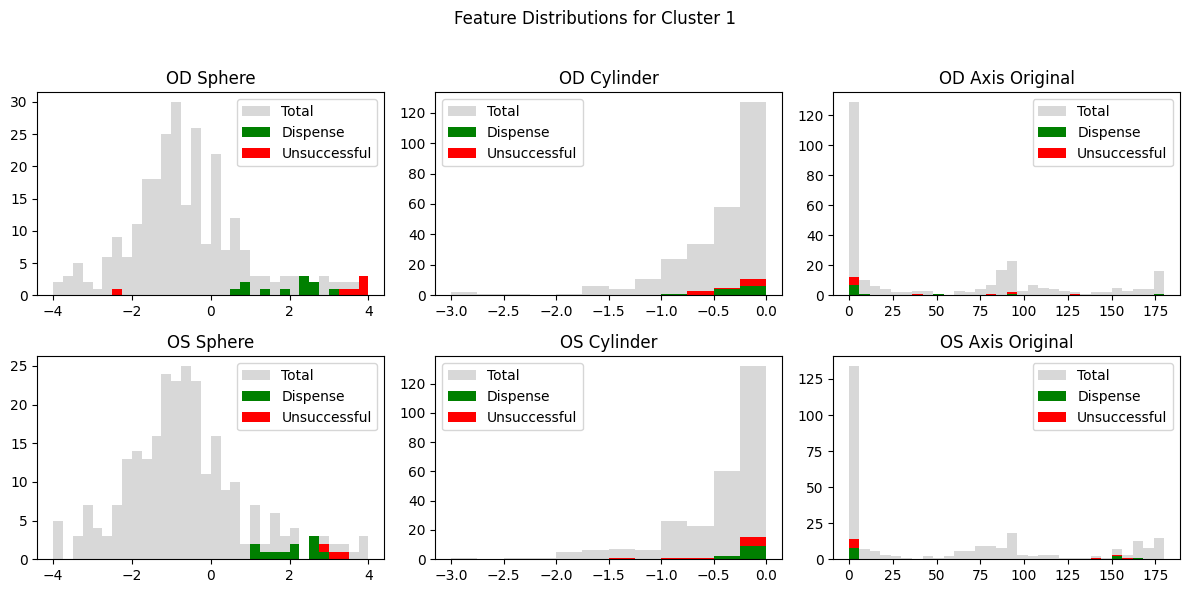

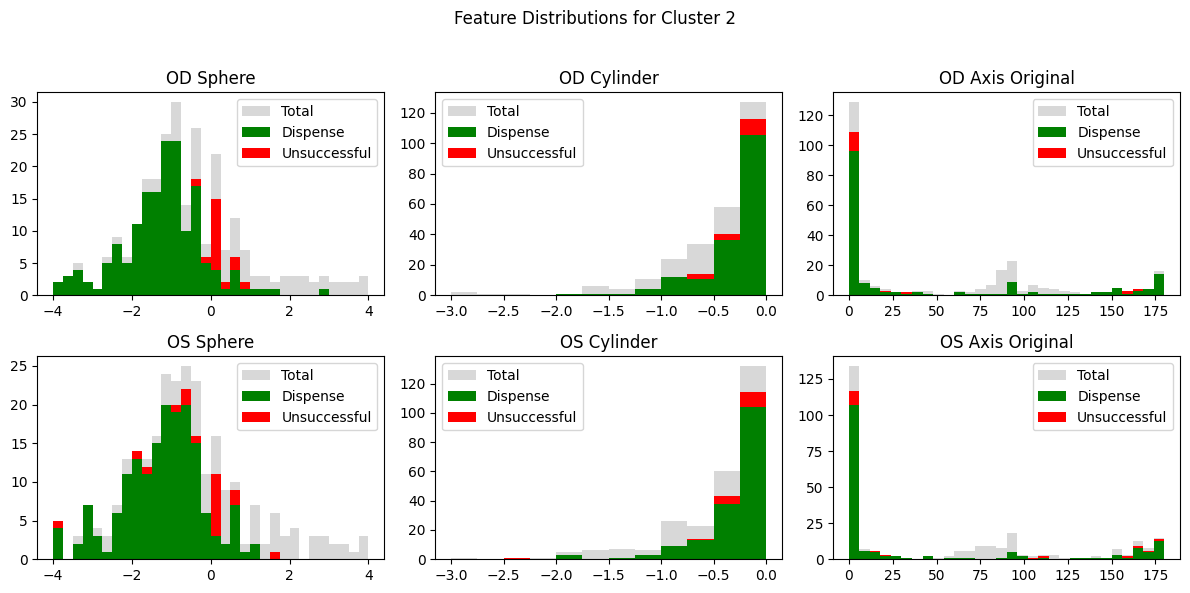

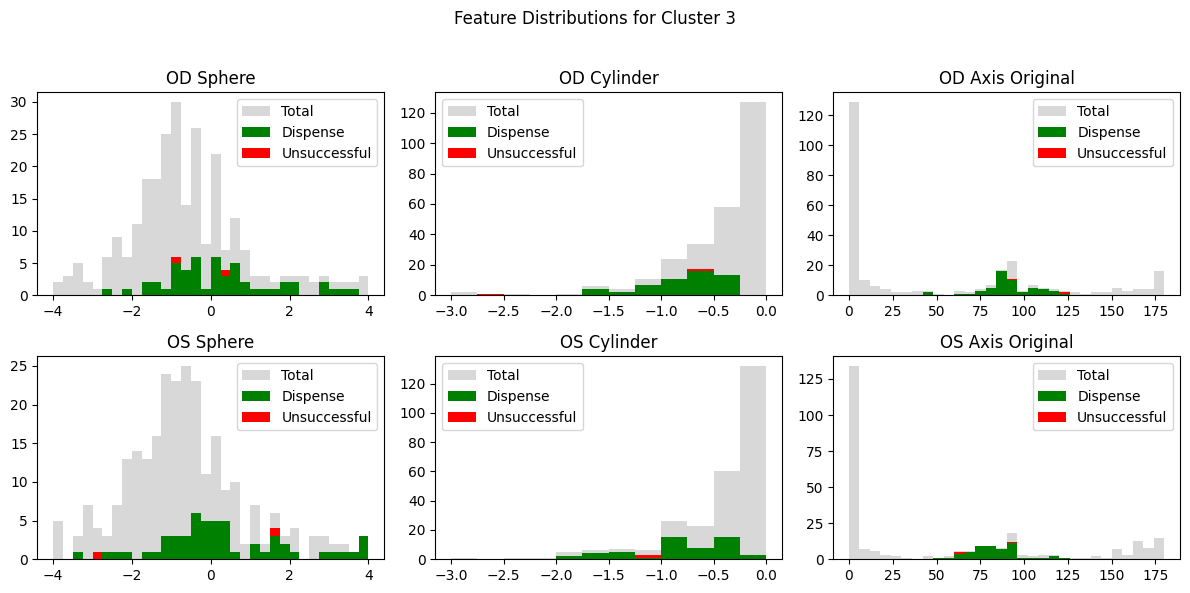

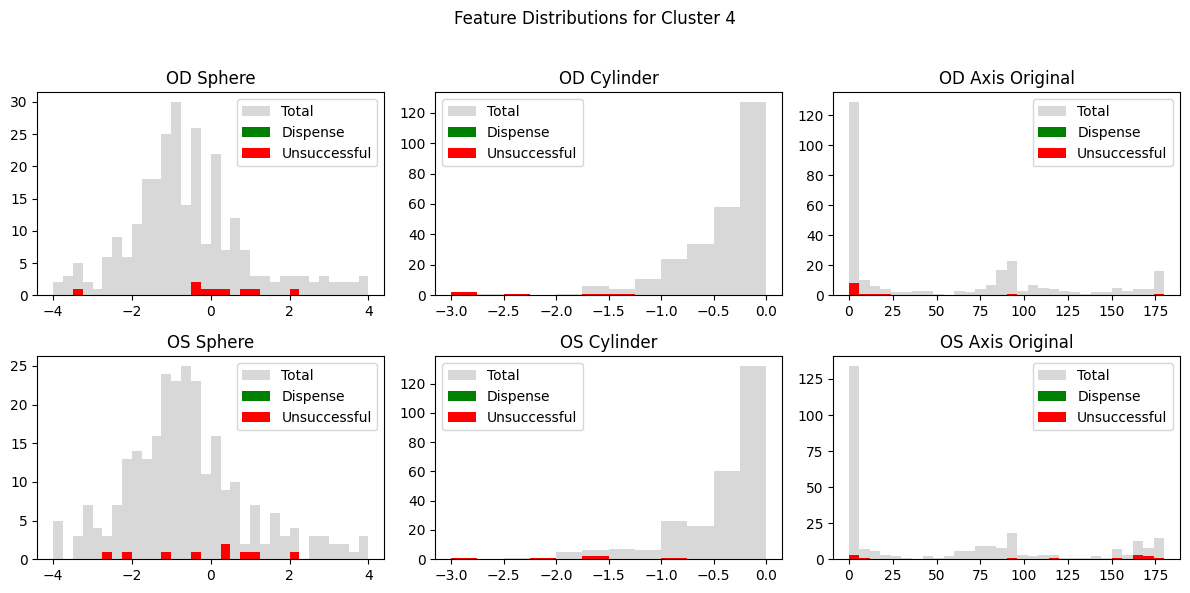

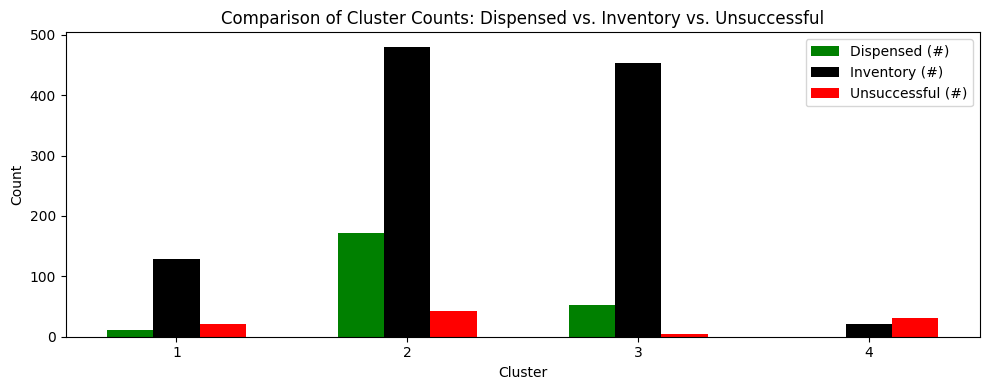

In [1]:
from analysis import launch
launch(False, 'sa', 4)

Number of pre-filtered glasses: 7
Number of glasses dispensed: 198
Number of removed unsuccessful searches that were very close in time: 37
Number of pre-filtered glasses: 10
Number of unsuccessful searches: 84
Number of glasses used for clustering: 282


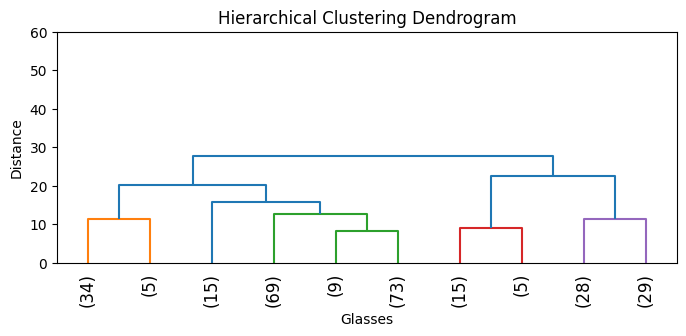

Number of removed unsuccessful searches that were same cluster and close in time: 11
cluster
1     32.0
2    111.0
3      0.0
4     55.0
Name: dispense_cluster_count, dtype: float64


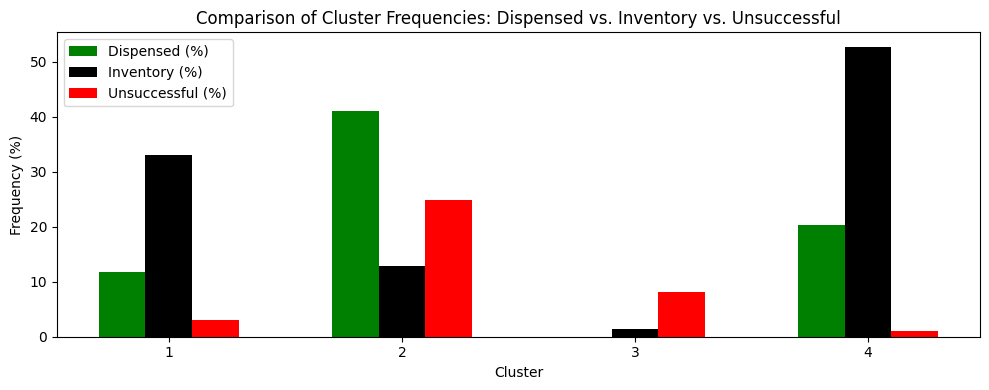

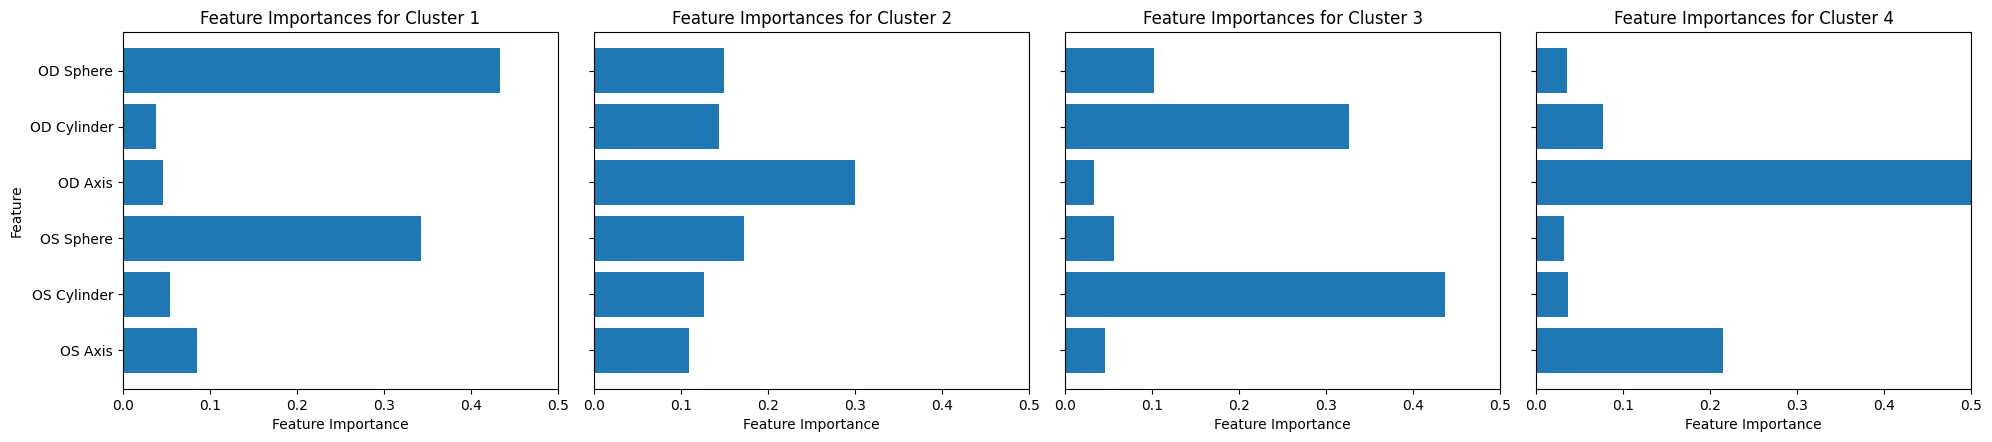

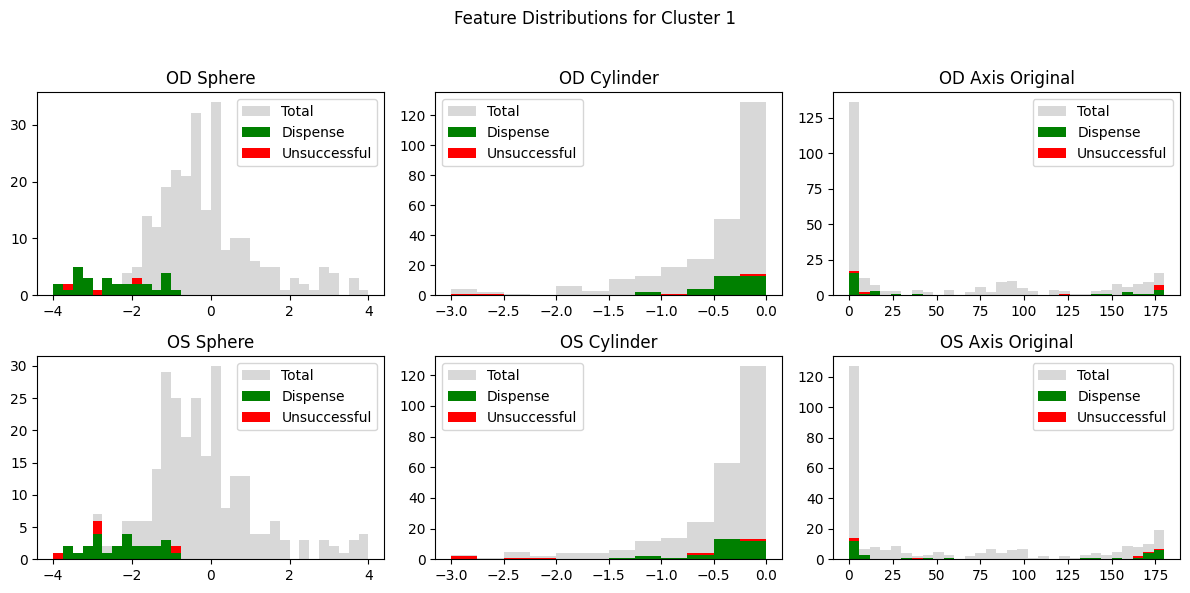

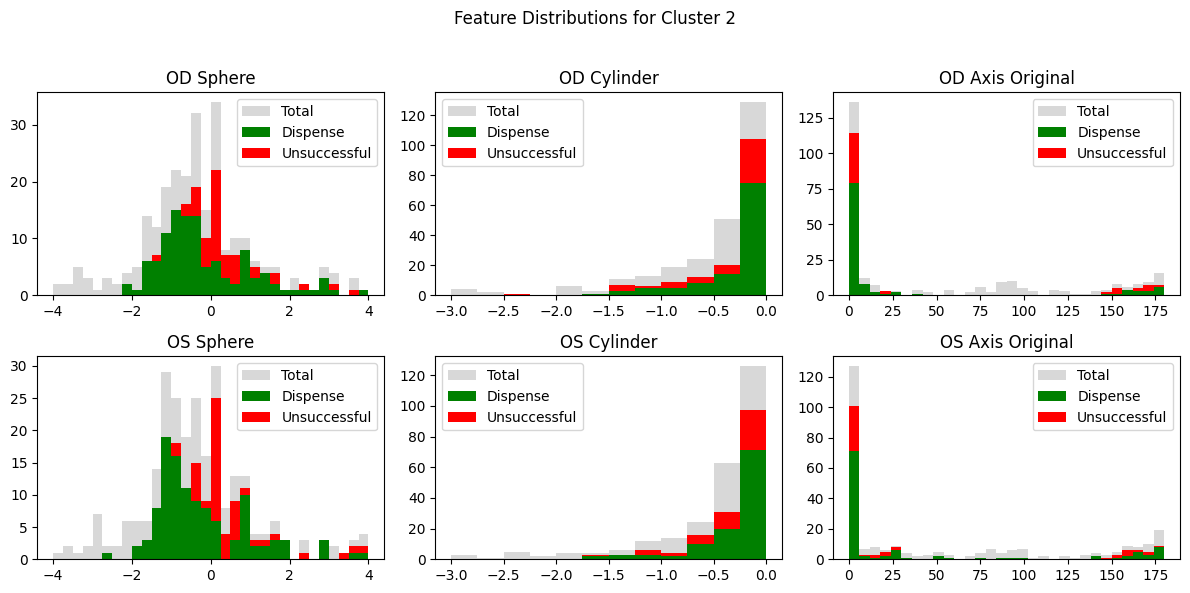

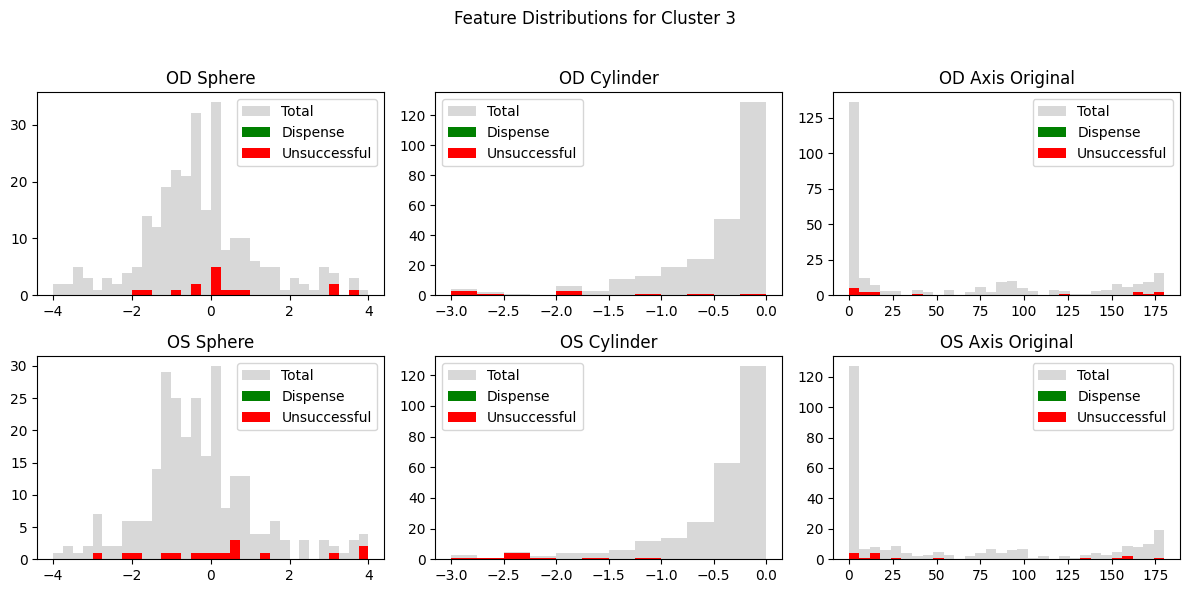

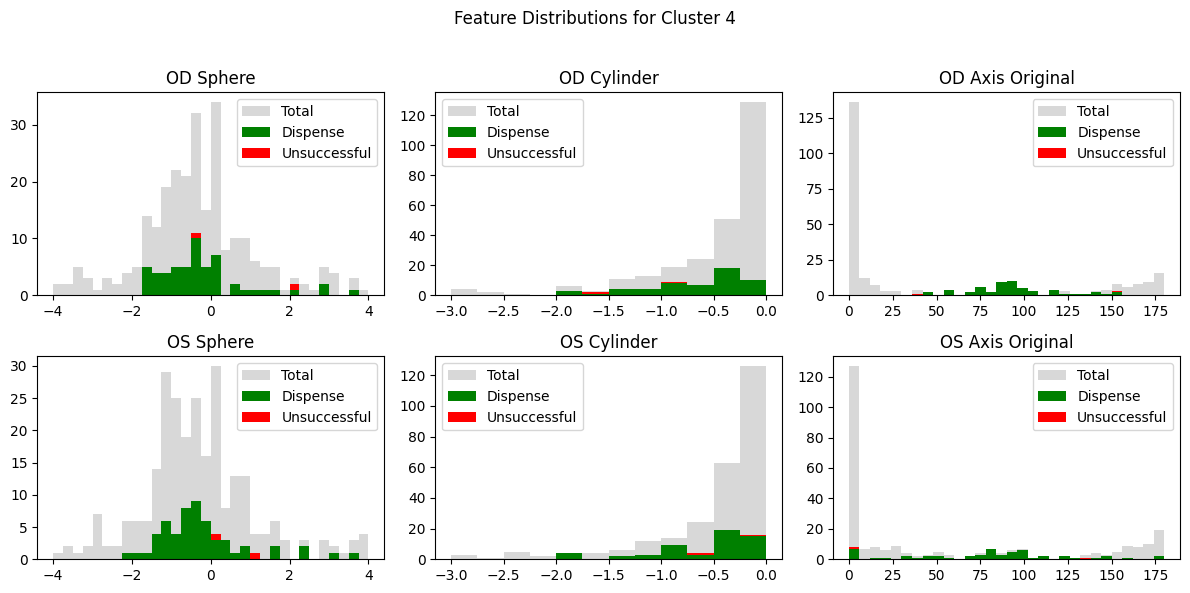

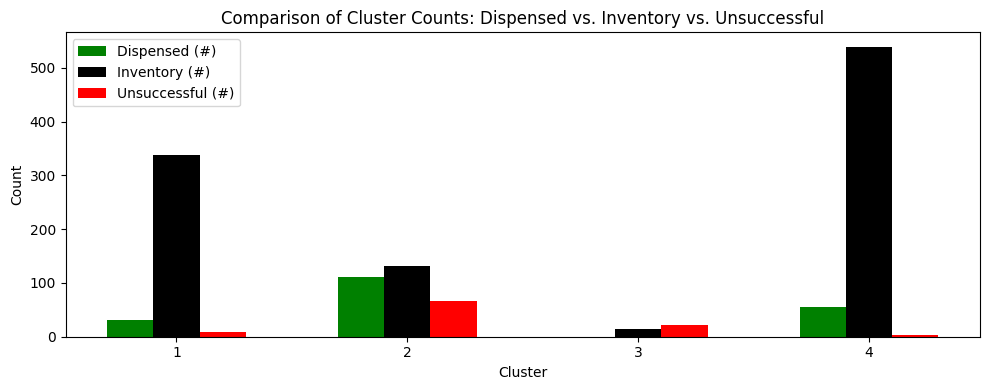

In [2]:
from analysis import launch
launch(False, 'sm', 4)

Number of pre-filtered glasses: 14
Number of glasses dispensed: 1052
Number of removed unsuccessful searches that were very close in time: 30
Number of pre-filtered glasses: 14
Number of unsuccessful searches: 137
Number of glasses used for clustering: 1189


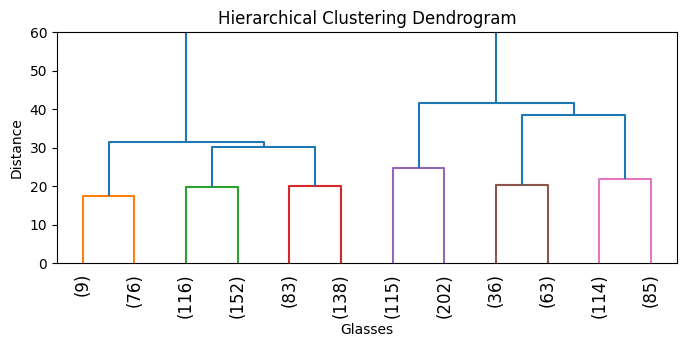

Number of removed unsuccessful searches that were same cluster and close in time: 14
cluster
1     72
2    485
3    249
4     73
5    173
Name: dispense_cluster_count, dtype: int64


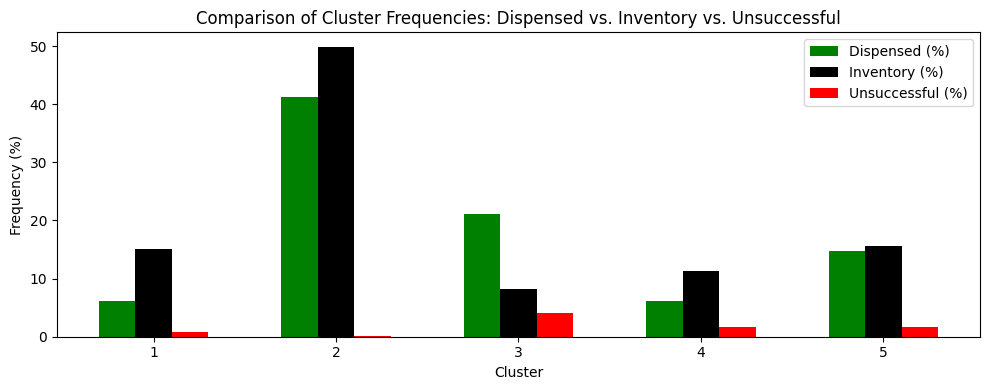

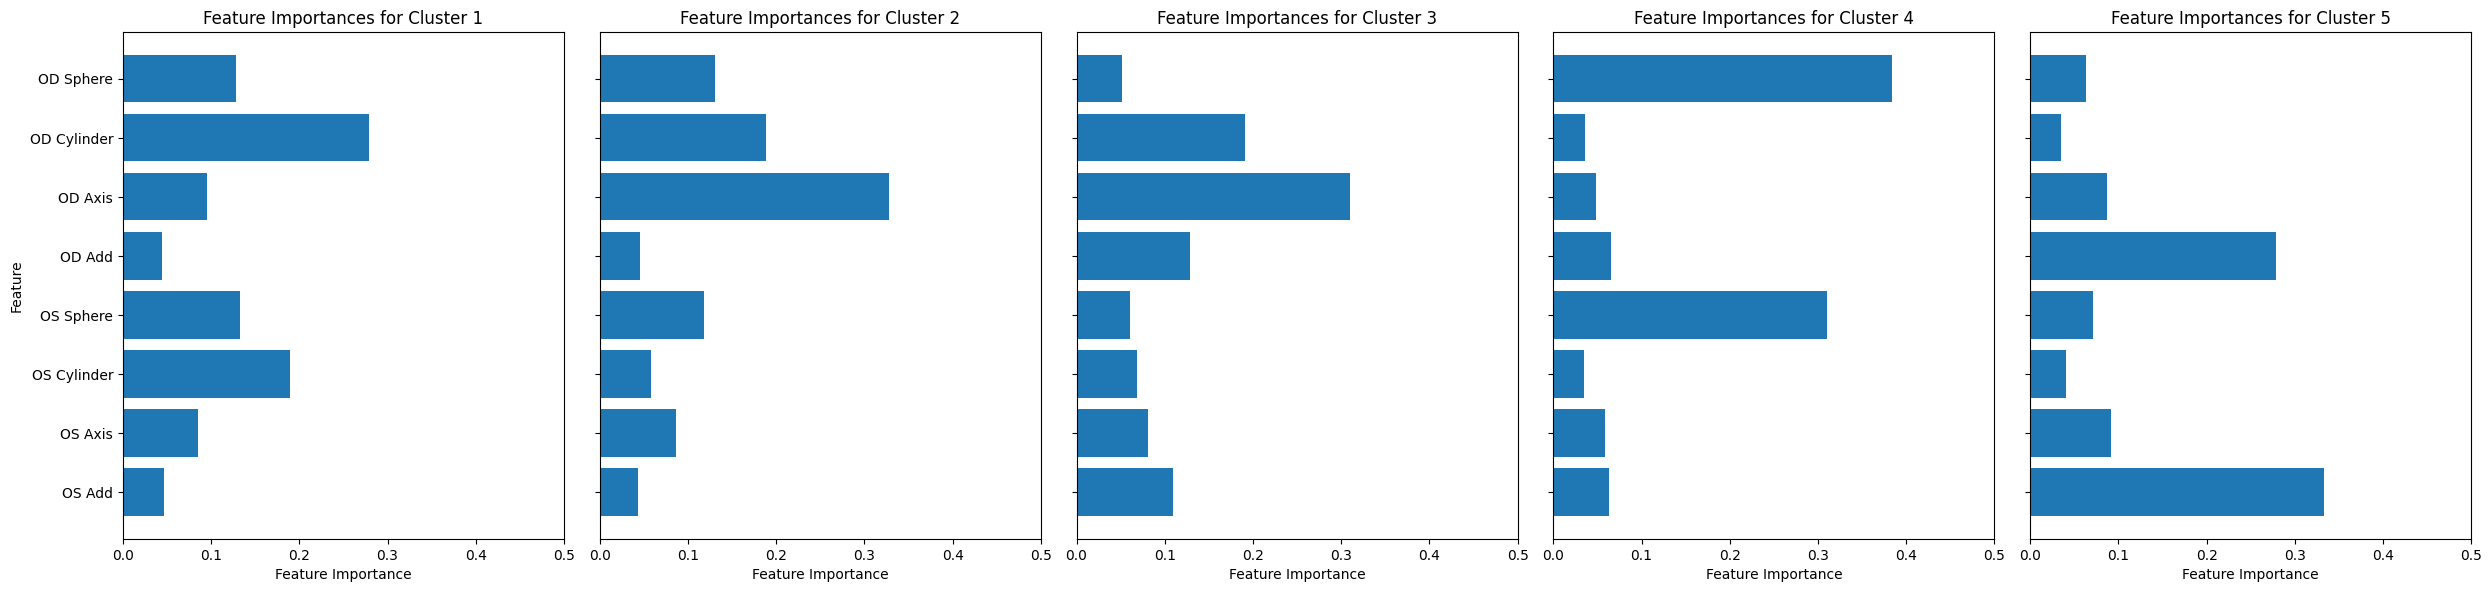

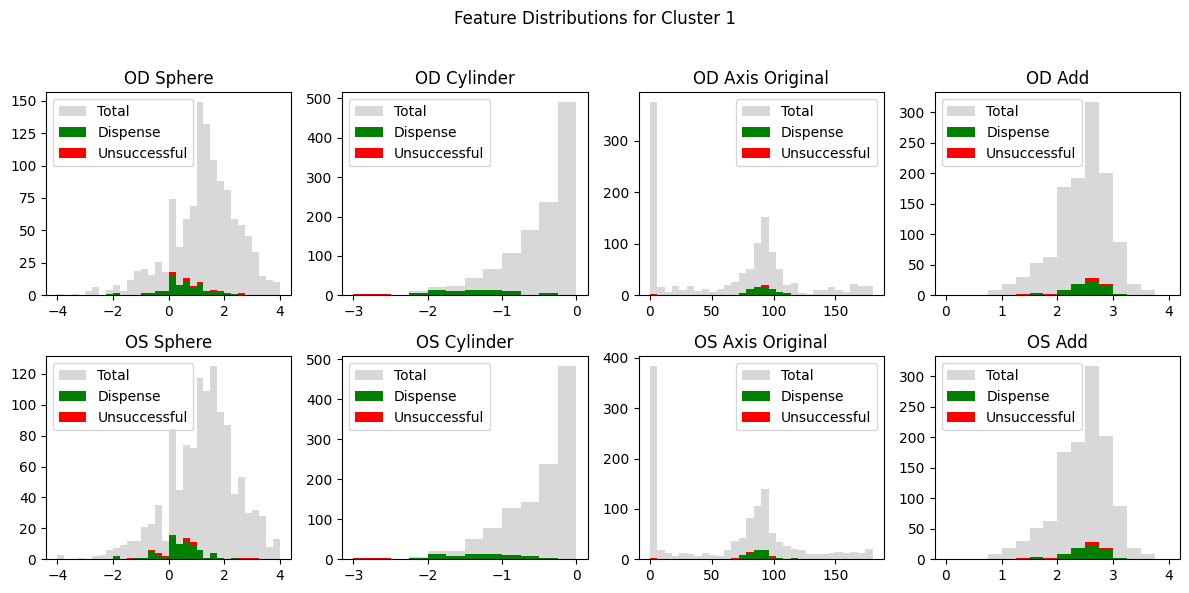

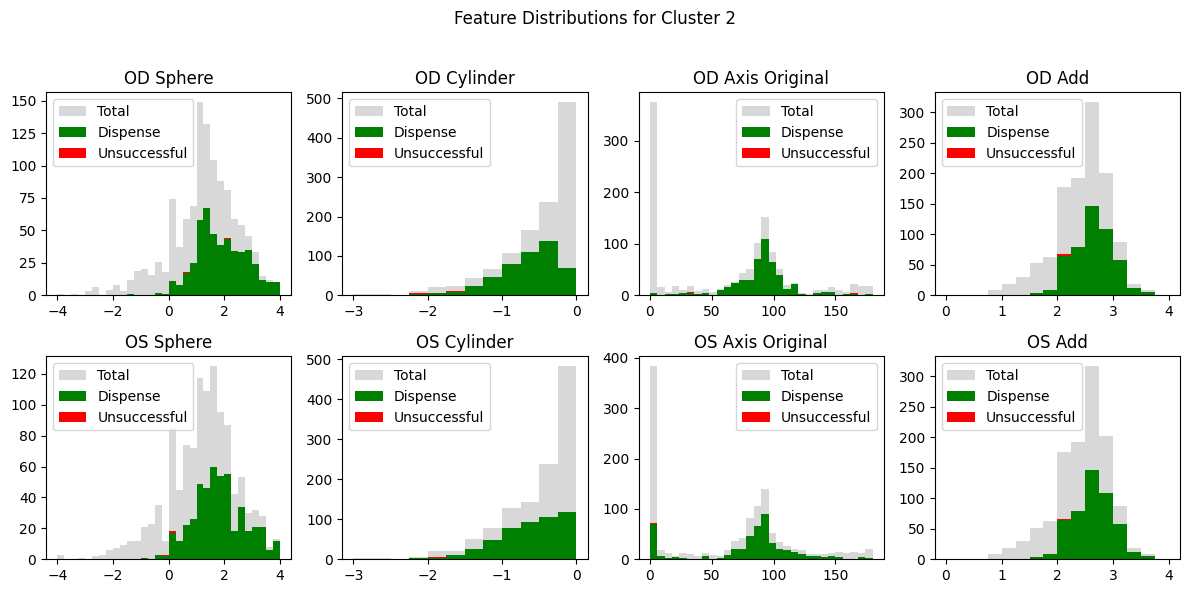

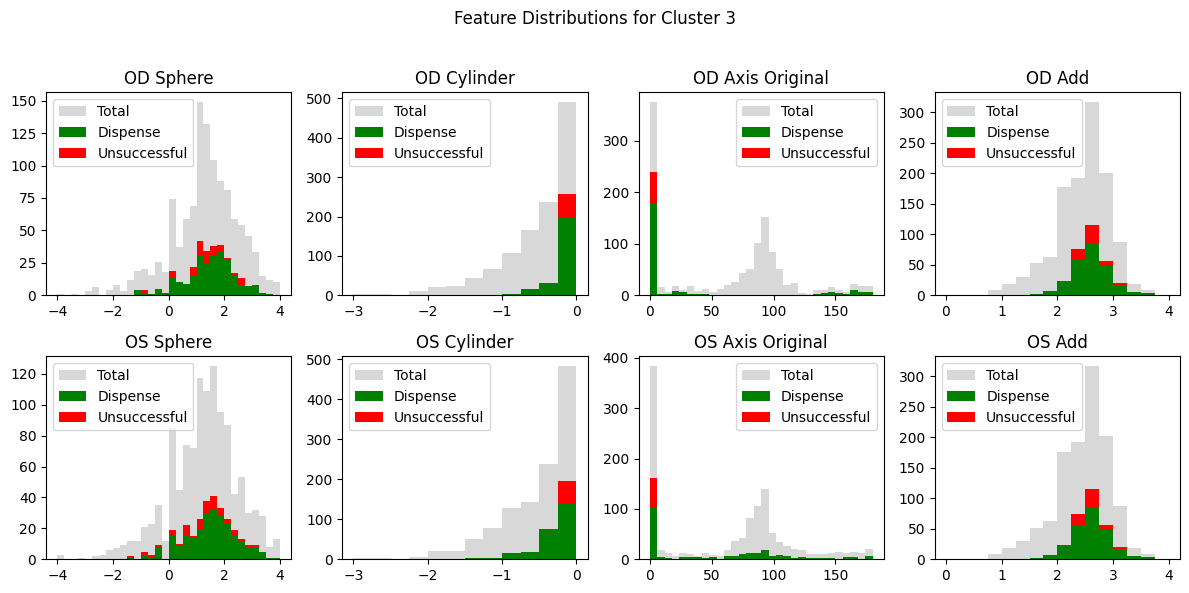

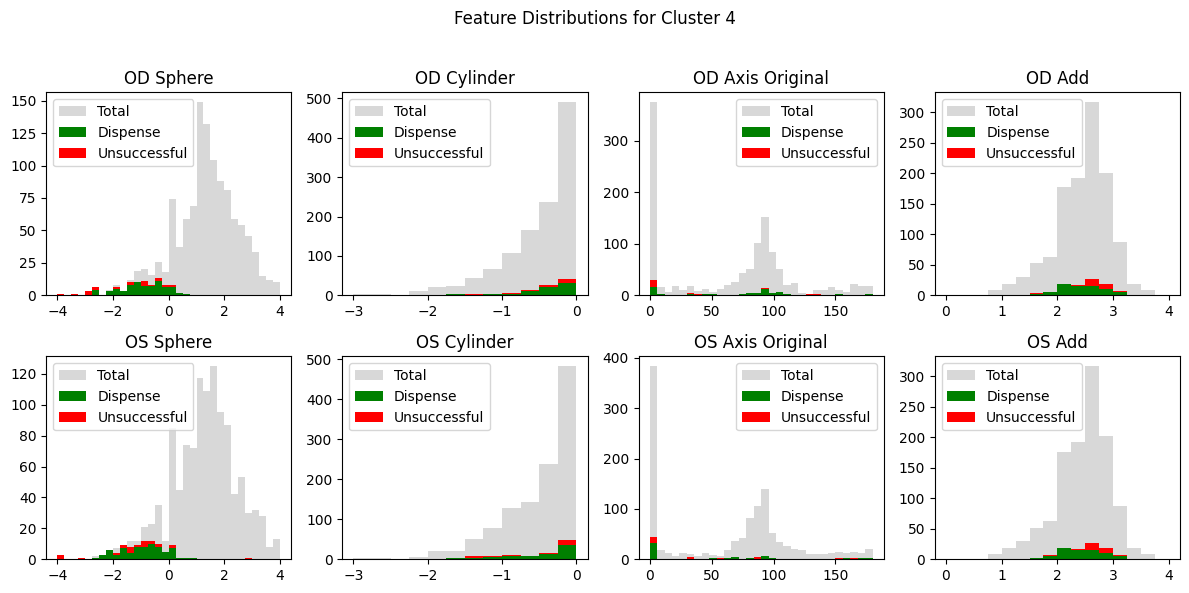

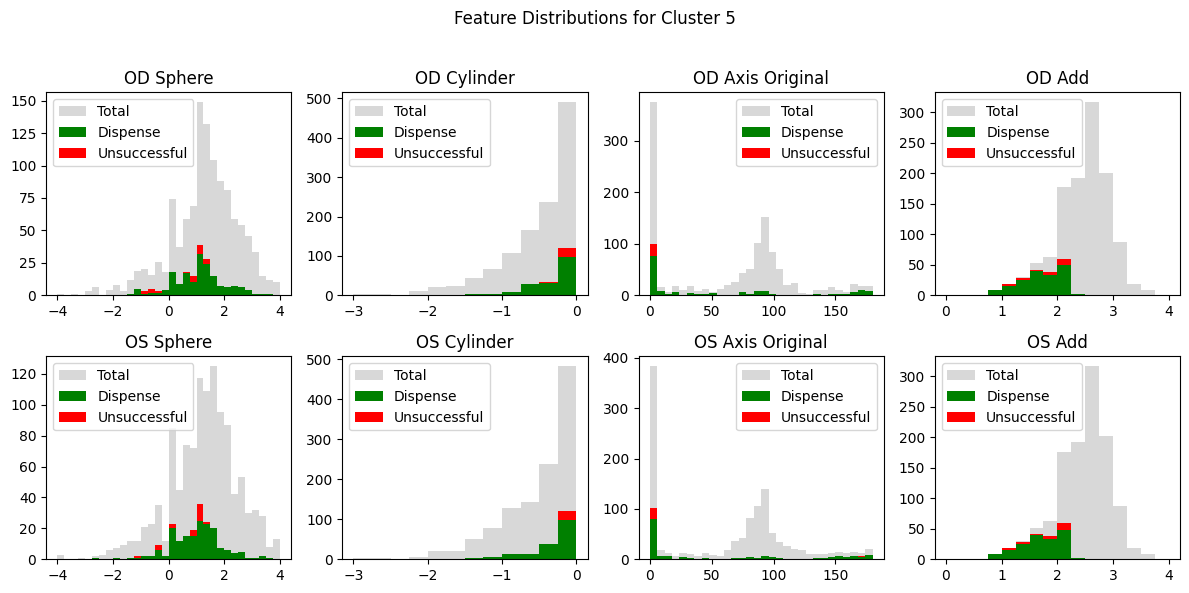

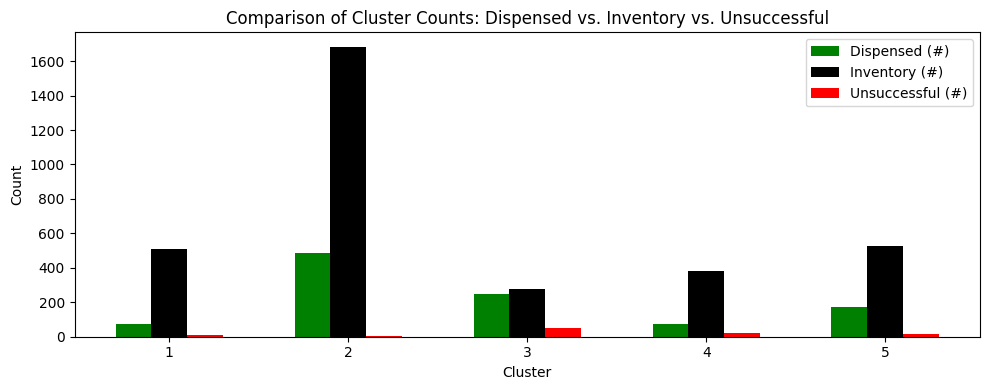

In [3]:
from analysis import launch
launch(True, 'sa', 5)

Number of pre-filtered glasses: 14
Number of glasses dispensed: 963
Number of removed unsuccessful searches that were very close in time: 65
Number of pre-filtered glasses: 9
Number of unsuccessful searches: 132
Number of glasses used for clustering: 1095


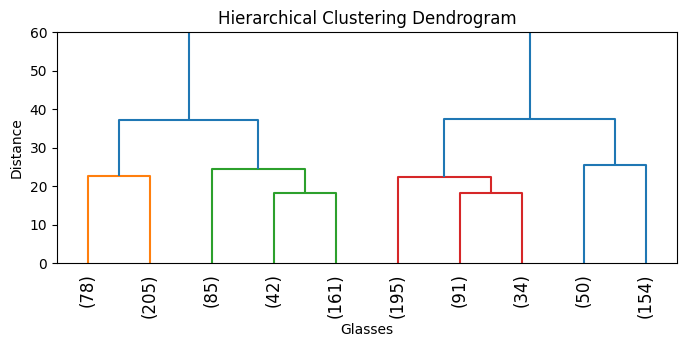

Number of removed unsuccessful searches that were same cluster and close in time: 15
cluster
1    259
2    218
3    310
4    176
Name: dispense_cluster_count, dtype: int64


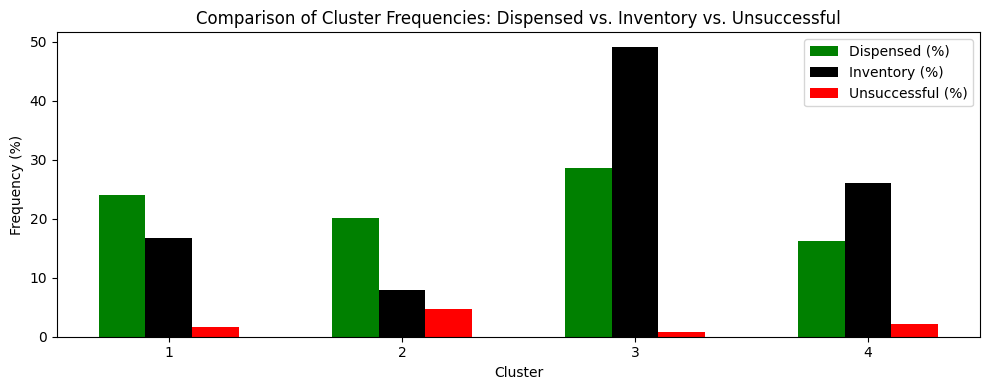

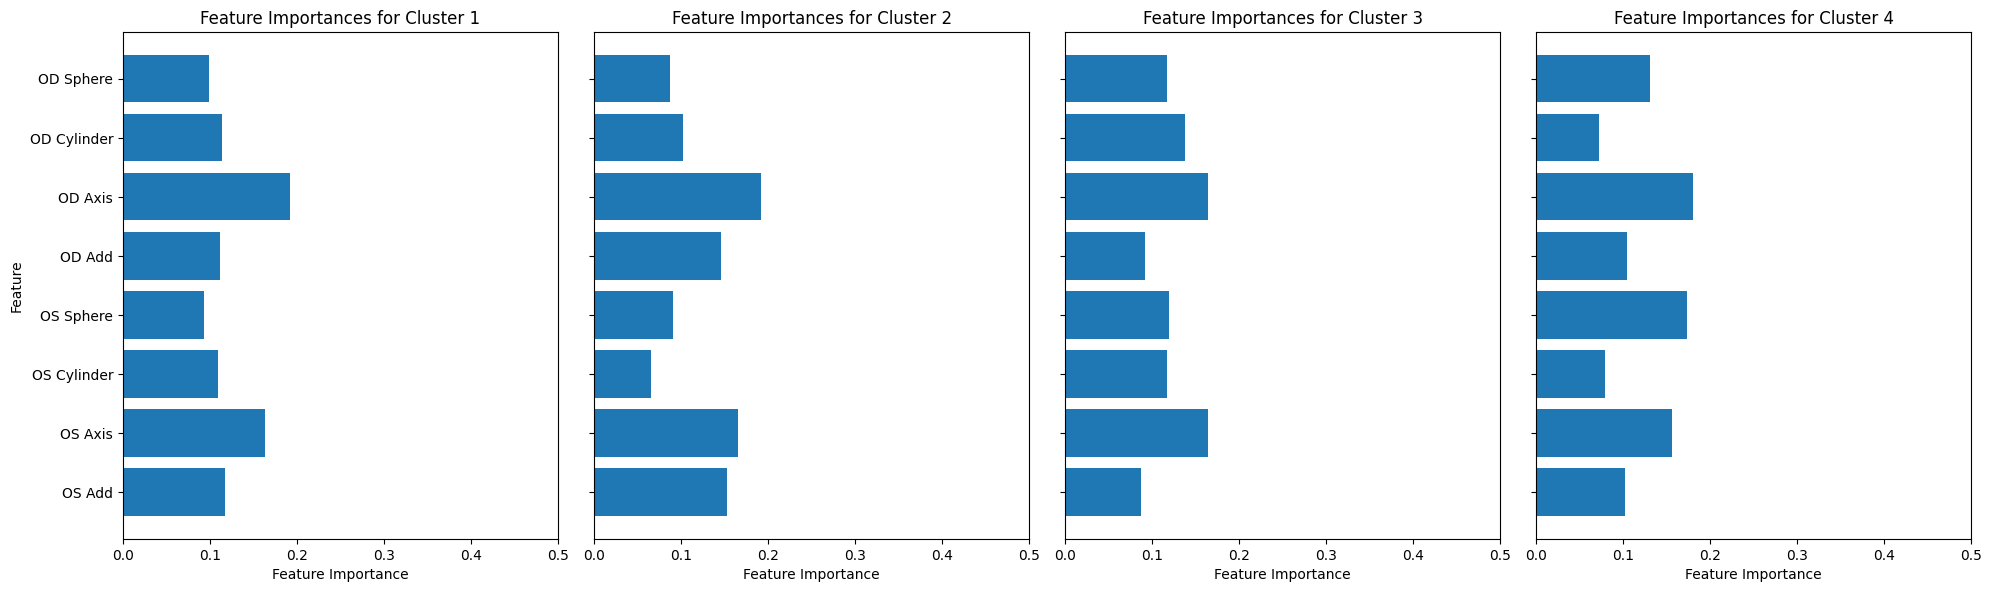

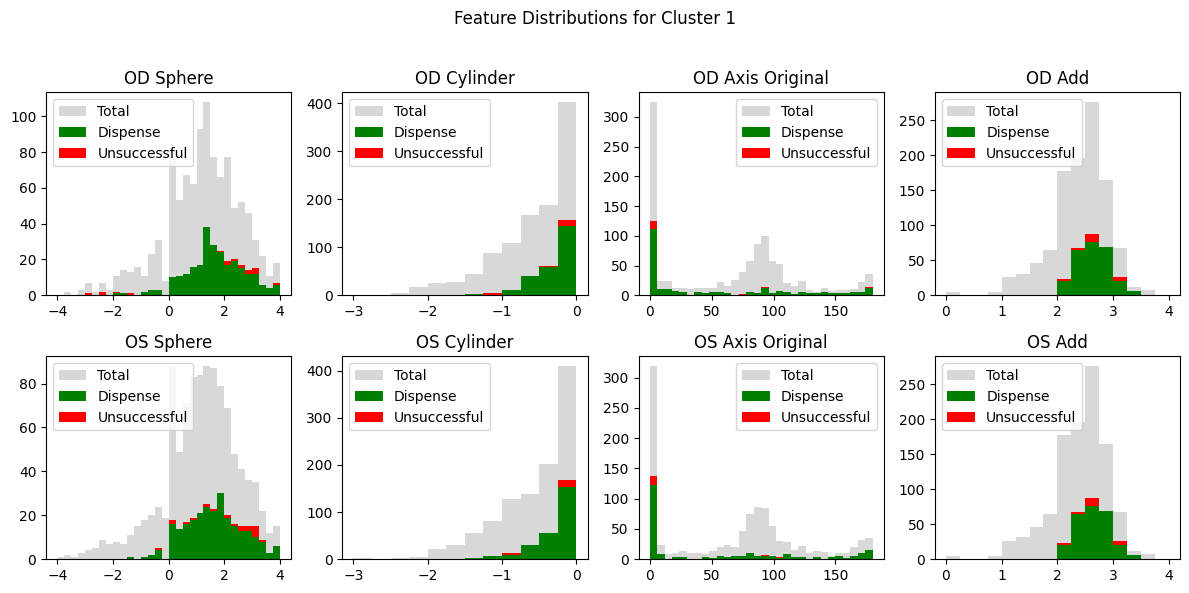

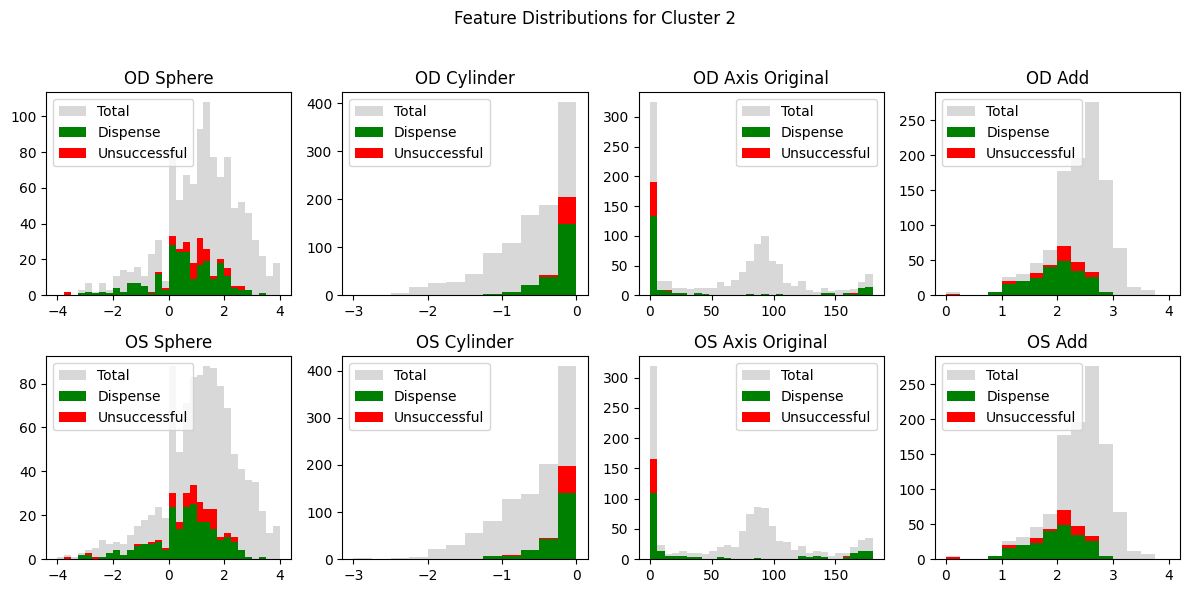

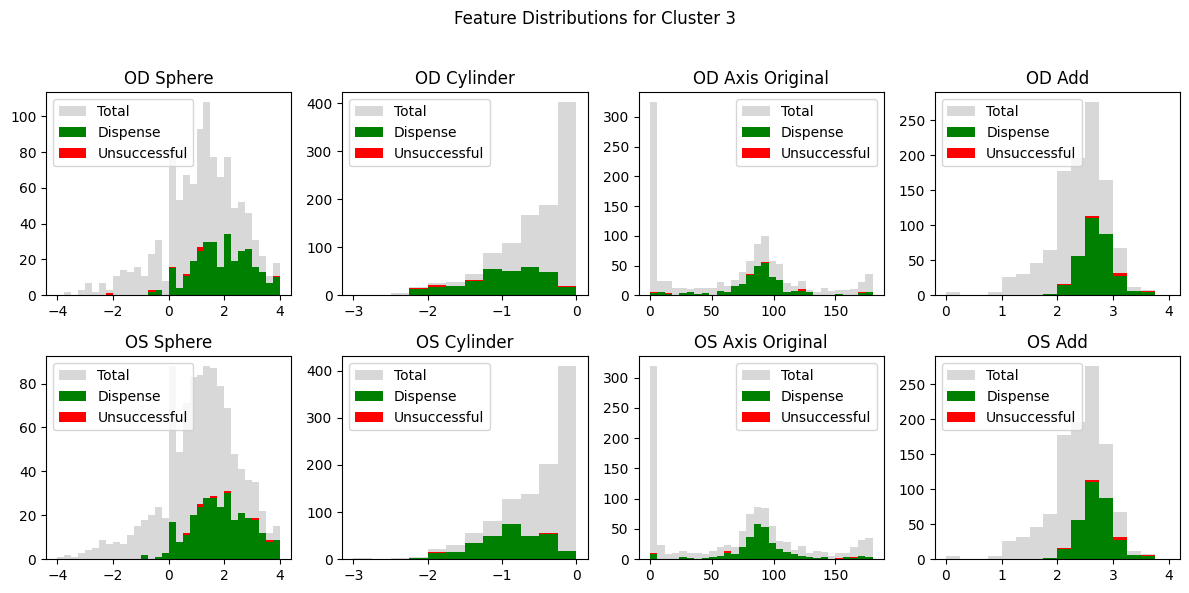

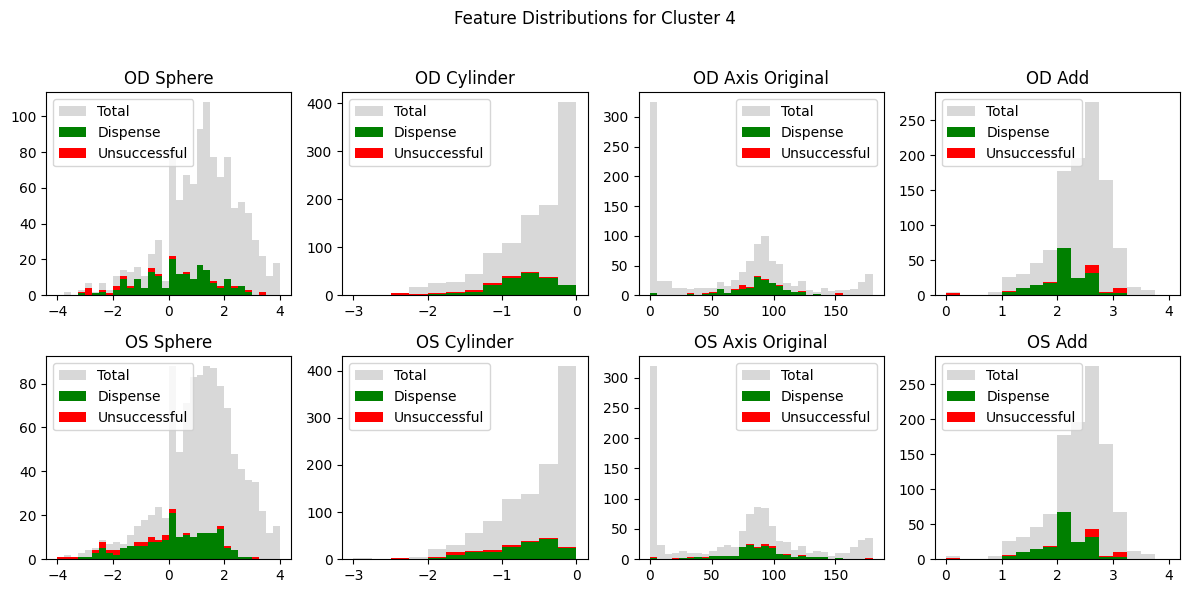

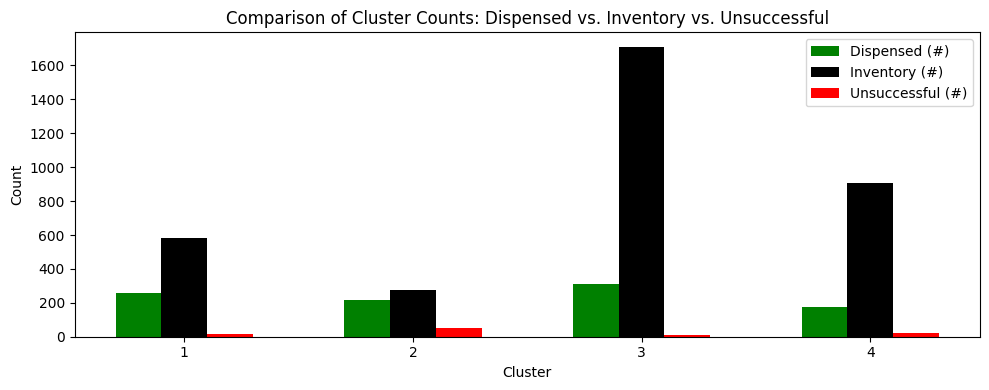

In [4]:
from analysis import launch
launch(True, 'sm', 4)